# **Download DATA SET here : https://www.kaggle.com/vetrirah/janatahack-independence-day-2020-ml-hackathon**

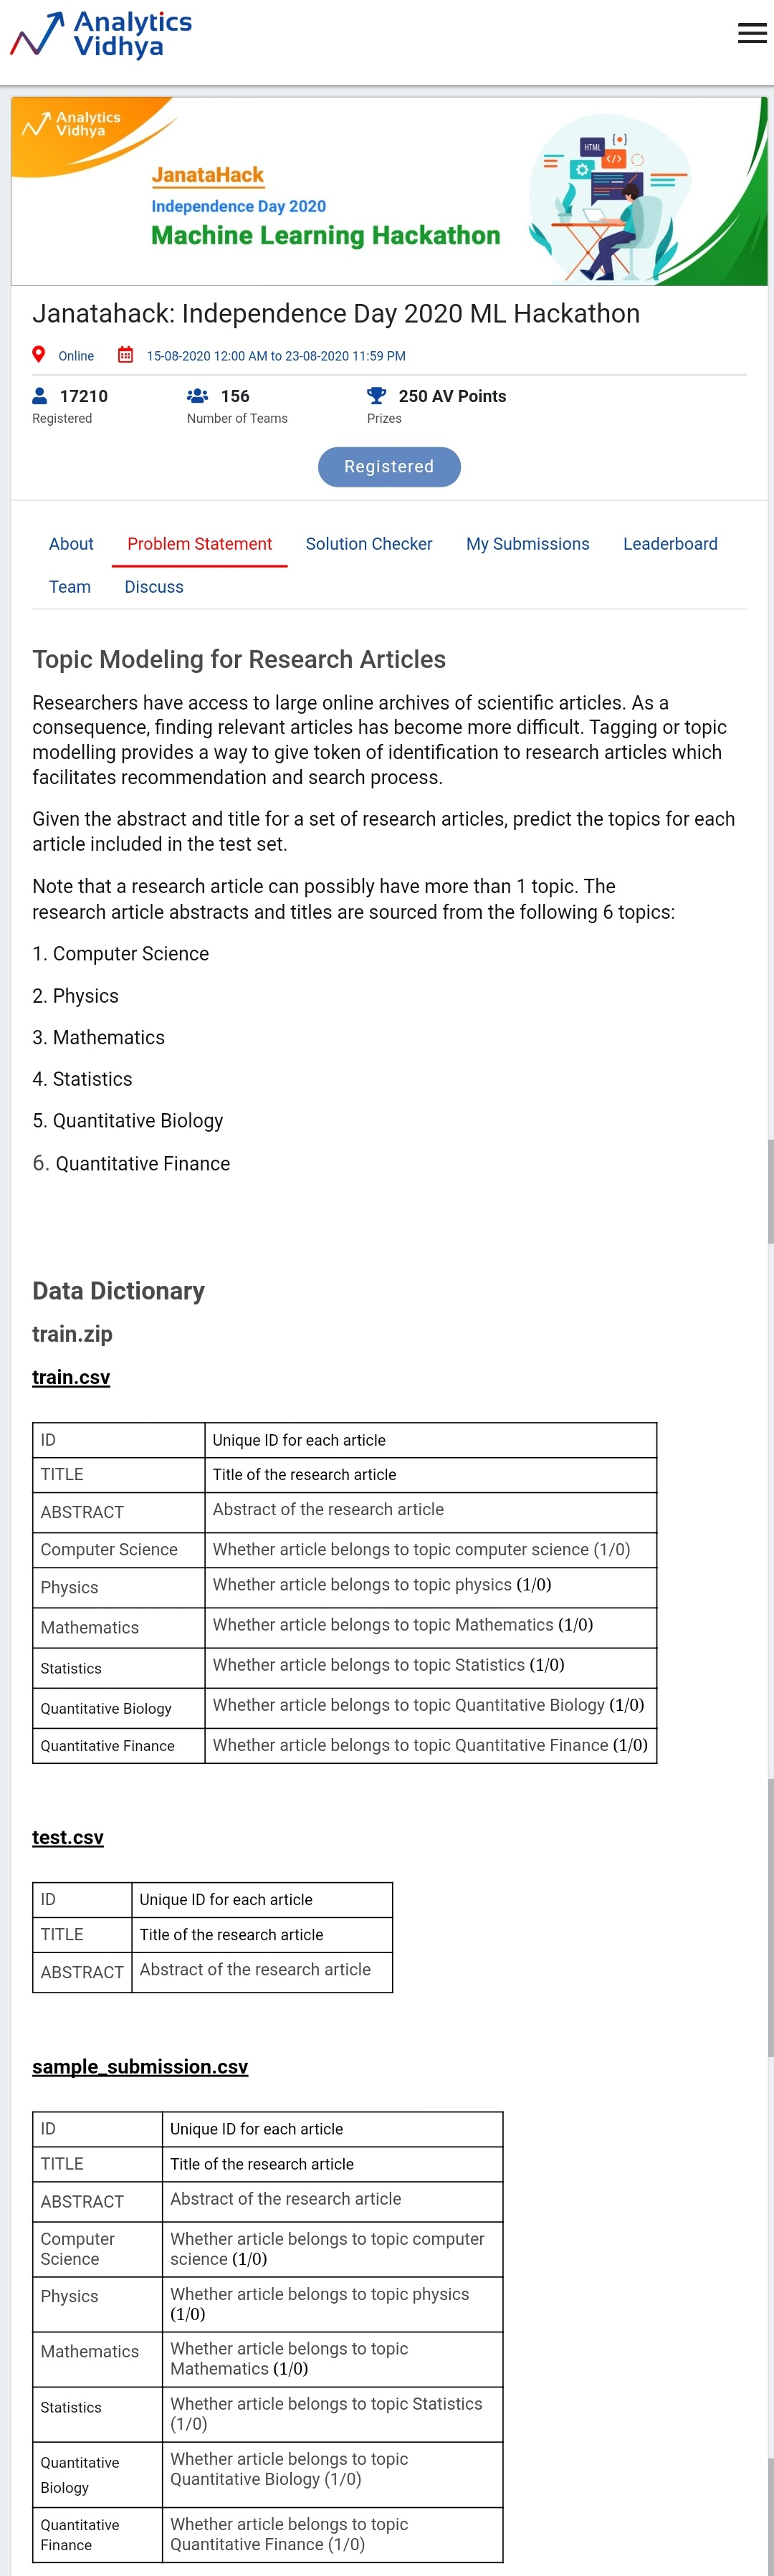

In [ ]:
!pip install --upgrade transformers
!pip install simpletransformers
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
!pip install pyspellchecker

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
# from google.colab import files
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import gc
from scipy.special import softmax
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import sklearn
from sklearn.metrics import log_loss
from sklearn.metrics import *
from sklearn.model_selection import *
from ast import literal_eval
import re
from spellchecker import SpellChecker
import random
from sklearn.preprocessing import LabelEncoder
import torch
pd.options.display.max_colwidth = 200

def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(2)

## Used simple transformers models - Roberta and Bert to reach Top 25 in Public Leaderboard :

In [ ]:
train = pd.read_csv('../input/janatahack-independence-day-2020-ml-hackathon/train.csv')
test = pd.read_csv('../input/janatahack-independence-day-2020-ml-hackathon/test.csv')
sample_sub = pd.read_csv('../input/janatahack-independence-day-2020-ml-hackathon/sample_submission.csv')
train.ABSTRACT = train.ABSTRACT.str.replace("\n"," ")
test.ABSTRACT = test.ABSTRACT.str.replace("\n"," ")

train["text"] = train["TITLE"] + train["ABSTRACT"]
test["text"] = test["TITLE"] + test["ABSTRACT"]

target_labels = ["Computer Science" ,"Physics" , "Mathematics", "Statistics" , "Quantitative Biology" , "Quantitative Finance"]
train['label'] = train[target_labels].values.tolist()

le = LabelEncoder()
train['label'] = le.fit_transform(train['label'].astype(str))
train = train[["text","label"]]
test = test[["text"]]
test["label"] = 0

import spacy, re
#Data Cleanup

def pre_process(df):
  df['text']=df['text'].str.replace('\n','')
  df['text']=df['text'].str.replace('\r','')
  df['text']=df['text'].str.replace('\t','')
    
  #This removes unwanted texts
  df['text'] = df['text'].apply(lambda x: re.sub(r'[0-9]','',x))
  df['text'] = df['text'].apply(lambda x: re.sub(r'[/(){}\[\]\|@,;.:-]',' ',x))
    
  #Converting all upper case to lower case
  df['text']= df['text'].apply(lambda s:s.lower() if type(s) == str else s)
    

  #Remove un necessary white space
  df['text']=df['text'].str.replace('  ',' ')

  #Remove Stop words
  nlp=spacy.load("en_core_web_sm")
  df['text'] =df['text'].apply(lambda x: ' '.join([word for word in x.split() if nlp.vocab[word].is_stop==False ]))
  return df

train = pre_process(train)
test = pre_process(test)

display(train)

wordcount = train['text'].str.count(' ') + 1
display(wordcount.mean())

display(test)

print(train['label'].nunique())

model_2 = ClassificationModel('roberta', 'roberta-base', use_cuda=True,num_labels=24, args={
                                                                         'train_batch_size':32,
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': 3,
                                                                         'max_seq_length': 256,
                                                                         'regression': False,
                                                                         'manual_seed': 2,
                                                                         "learning_rate":5e-5,
                                                                         'weight_decay':0.0,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,
                                                                         "silent": False}
                                                                         )
                              
                                                                         

model_2.train_model(train)

tst_result_2, tst_model_outputs_2, tst_wrong_predictions_2 = model_2.eval_model(test)

preds_2 = softmax(tst_model_outputs_2,axis=1)

finalpreds_2 = [np.argmax(x) for x in preds_2]
sample_sub["target"] = finalpreds_2
sample_sub["target"] = le.inverse_transform(sample_sub["target"])
sample_sub.loc[:,'target'] = sample_sub.loc[:,'target'].apply(lambda x: literal_eval(x))
sample_sub[target_labels] = pd.DataFrame(sample_sub.target.tolist(), index= sample_sub.index)
sample_sub.drop("target",axis=1,inplace = True)

sub_file_name = "Submission_BEST_FINAL_2_Bert-Uncased_max_seq_256_epochs_2.csv"
sample_sub.to_csv(sub_file_name,index = False)

In [ ]:
model_3 = ClassificationModel('bert', 'bert-base-uncased', use_cuda=True,num_labels=24, args=
                                                                        {
                                                                         'train_batch_size':32,
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': 2,
                                                                         'max_seq_length': 256,
                                                                         'regression': False,
                                                                         'manual_seed': 2,
                                                                         "learning_rate":5e-5,
                                                                         'weight_decay':0.0,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,
                                                                         "silent": False
                                                                         }
                              
                                                                         )

model_3.train_model(train)

tst_result_3, tst_model_outputs_3, tst_wrong_predictions_3 = model_3.eval_model(test)

preds_3 = softmax(tst_model_outputs_3,axis=1)

finalpreds_3 = [np.argmax(x) for x in preds_3]
sample_sub["target"] = finalpreds_3
sample_sub["target"] = le.inverse_transform(sample_sub["target"])
sample_sub.loc[:,'target'] = sample_sub.loc[:,'target'].apply(lambda x: literal_eval(x))
sample_sub[target_labels] = pd.DataFrame(sample_sub.target.tolist(), index= sample_sub.index)
sample_sub.drop("target",axis=1,inplace = True)

sub_file_name = "Submission_BEST_FINAL_2_Bert-Uncased_max_seq_256_epochs_2.csv"
sample_sub.to_csv(sub_file_name,index = False)


In [ ]:
# Ensemble : "Blending of Reboerta-base + Bert-base-uncased" :

sub_file_name = "FINAL_AV_SUBMISSION_Ensemble_bert-uncased_roberta-base_0.80_0.80.csv"
preds_final = preds_2*0.80 + preds_3*0.80

finalpreds_3 = [np.argmax(x) for x in preds_final]

sample_sub["target"] = finalpreds_3
sample_sub["target"] = le.inverse_transform(sample_sub["target"])
sample_sub.loc[:,'target'] = sample_sub.loc[:,'target'].apply(lambda x: literal_eval(x))
sample_sub[target_labels] = pd.DataFrame(sample_sub.target.tolist(), index= sample_sub.index)
sample_sub.drop("target",axis=1,inplace = True)
sample_sub.to_csv(sub_file_name,index = False)
